# **Library imports**

In [1]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from scipy.stats import randint
import matplotlib.pyplot as plt

# **File imports**

In [2]:
# folder for txt files
folder = 'qws1_dataset/*.txt'

# list of files
files = glob.glob(folder)

# number of files
count = 1
for file in files:
    print(f'File number {count} - {file}')
    count += 1

File number 1 - qws1_dataset\qws1.txt


In [3]:
# DataFrame creation using files avaiable
df_list = []

for file in files:
    try:
        df_list.append(pd.read_csv(file, sep=','))
    except Exception as e:
        print(f"Skipping {file}: {e}")

if df_list:
    df = pd.concat(df_list, ignore_index=True)
else:
    print("No valid files")

In [4]:
# Drop leakage columns
leakage_cols = ['Service Name', 'WSDL Address', 'Latency', 'Best Practices']
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])

qos_features = ['Response Time', 'Availability', 'Throughput', 'Successability', 'Reliability', 'Compliance', 'Documentation']
missing_features = [col for col in qos_features if col not in df.columns]
if missing_features:
    raise KeyError(f"Missing features: {missing_features}")
X = df[qos_features].copy()

target_col = 'WsRF: Web Service Relevancy Function (%)'
if target_col not in df.columns:
    raise KeyError(f"Target column '{target_col}' not found.")
y = df[target_col].copy()

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (291, 7), Test shape: (73, 7)


In [5]:
def build_pipeline(model, scale=True):
    '''Function to build models.
    As the arguments, chose the type of model and define scalling as True or False
    # Example usage:

    pipeline = build_pipeline(LinearRegression(), scale=True)
    pipeline.fit(X_train, y_train)'''

    steps = [('imputer', SimpleImputer(strategy='median'))]
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('model', model))
    return Pipeline(steps=steps)

# Example usage:
pipeline = build_pipeline(LinearRegression(), scale=True)
pipeline.fit(X_train, y_train)

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


Pipeline with three steps:
- Imputer: replaces missing values with the median.
- Scaler: standardizes features (mean=0, std=1).
- Model: fits a LinearRegression model.

Pipeline is trained and ready to predict.

In [6]:
# Baseline prediction: mean of training target
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)

# Compute RMSE and MAE
baseline_rmse = root_mean_squared_error(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)

print(f"Baseline RMSE: {baseline_rmse:.2f}, MAE: {baseline_mae:.2f}")

Baseline RMSE: 13.41, MAE: 10.69


- Since this is the baseline, setting a reference point. Any model you train should aim for an RMSE lower than 13.41 to be considered better than the baseline

In [7]:
# Define models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    # Scale only for LinearRegression
    scale = True if name == 'LinearRegression' else False
    pipeline = build_pipeline(model, scale=scale)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Display results
for model_name, metrics in results.items():
    print(f"{model_name}: RMSE={metrics['RMSE']:.2f}, MAE={metrics['MAE']:.2f}, R²={metrics['R²']:.3f}")

results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Model', 'RMSE', 'MAE', 'R²']
results_df

LinearRegression: RMSE=1.90, MAE=2.63, R²=0.928
RandomForest: RMSE=1.95, MAE=2.51, R²=0.919
XGBoost: RMSE=1.95, MAE=2.69, R²=0.919


,Model,RMSE,MAE,R²
0,LinearRegression,1.897023,2.632853,0.927807
1,RandomForest,1.950324,2.511370,0.919345
2,XGBoost,1.952324,2.685471,0.919013


| Model | RMSE | MAE | $R^{2}$ |
|--- | --- | --- | --- |
| Linear Regression | 1.8970233923169415 | 2.6328531950906426 | 0.927806724857026 |
| Random Forest | 1.9503235210092447 | 2.5113698630136994 | 0.9193447515586426 |
| XGBoost | 1.952323566040874 | 2.6854708194732666 | 0.9190133810043335 |

Insights:
- RMSE and MAE lower than baseline RMSE (13.4).
- Models are adding significant predictive value compared to a naive mean predictor.
- LinearRegression has the lowest RMSE (1.897) and highest R² (0.928).
- All models have R² > 0.91, meaning they explain over 91% of the variance in the target.
- This indicates strong predictive power and good feature relevance.

# **Tuning - RandomizedSearchCV**

Hyperparameters for Linear Regression:
- fit_intercept: Whether to calculate the intercept (True/False).
- positive: Force coefficients to be positive (True/False).
- normalize: Deprecated in newer versions (use StandardScaler instead).
- n_jobs: For parallel computation (usually not critical here).

In [8]:
# Parameter grid for LinearRegression
param_grid_lr = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

# Build pipeline with scaling (important for LinearRegression)
lr_pipeline = build_pipeline(LinearRegression(), scale=True)

# RandomizedSearchCV
lr_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_grid_lr,
    n_iter=4,  # small because few params
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

lr_search.fit(X_train, y_train)

print("Best Params:", lr_search.best_params_)
print("Best CV RMSE:", -lr_search.best_score_)

Best Params: {'model__positive': False, 'model__fit_intercept': True}
Best CV RMSE: 2.8869817582030537


In [9]:
# Define parameter grid
param_grid_rf = {
    'model__n_estimators': randint(50, 300),
    'model__max_depth': randint(3, 20),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

# Build pipeline (no scaling for RandomForest)
rf_pipeline = build_pipeline(RandomForestRegressor(random_state=42), scale=False)

# RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("Best Params:", rf_search.best_params_)
print("Best CV RMSE:", -rf_search.best_score_)

Best Params: {'model__max_depth': 14, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 268}
Best CV RMSE: 3.0891524169502786


In [10]:
param_grid_xgb = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0]
}

xgb_pipeline = build_pipeline(XGBRegressor(random_state=42), scale=False)

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("Best Params:", xgb_search.best_params_)
print("Best CV RMSE:", -xgb_search.best_score_)

Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 291, 'model__subsample': 0.6}
Best CV RMSE: 2.3284844160079956


LinearRegression:
1. Tests combinations of fit_intercept and positive using RandomizedSearchCV with 5-fold CV.
2. Finds the best configuration based on lowest RMSE.

RandomForest:
1. Randomly samples values for n_estimators, max_depth, min_samples_split, and min_samples_leaf.
2. Runs 20 iterations with 5-fold CV.
3. Returns best parameters and best cross-validated RMSE.

XGBoost:
1. Samples n_estimators, max_depth, learning_rate, and subsample.
2. Also uses 20 iterations and 5-fold CV.
3. Returns best parameters and best CV RMSE.

## Prediction

In [11]:
best_lr = lr_search.best_estimator_
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# Predict and evaluate
for name, model in [('LinearRegression', best_lr), ('RandomForest', best_rf), ('XGBoost', best_xgb)]:
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

LinearRegression: RMSE=3.60, MAE=2.63, R²=0.928
RandomForest: RMSE=3.83, MAE=2.51, R²=0.918
XGBoost: RMSE=2.75, MAE=1.80, R²=0.958


1. Extract best models
2. Evaluate tuned models on test set

## Comparison

In [12]:
# ---- Baseline ----
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)
baseline_rmse = root_mean_squared_error(y_test, baseline_pred)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

previous_results = results_df.copy()
previous_results['Model'] = previous_results['Model'] + ' (Untuned)'

# ---- Tuned Results ----
tuned_data = []
for name, model in [('LinearRegression', best_lr), ('RandomForest', best_rf), ('XGBoost', best_xgb)]:
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    tuned_data.append({'Model': f'{name} (Tuned)', 'RMSE': rmse, 'MAE': mae, 'R²': r2})

tuned_results = pd.DataFrame(tuned_data)

# ---- Baseline Row ----
baseline_row = pd.DataFrame([{'Model': 'Baseline', 'RMSE': baseline_rmse, 'MAE': baseline_mae, 'R²': baseline_r2}])

# ---- Combine All ----
comparison_df = pd.concat([baseline_row, previous_results, tuned_results], ignore_index=True)

print("\nComparison Table:")
comparison_df


Comparison Table:


,Model,RMSE,MAE,R²
0,Baseline,13.408001,10.687379,-0.002153
1,LinearRegression (Untuned),1.897023,2.632853,0.927807
2,RandomForest (Untuned),1.950324,2.511370,0.919345
3,XGBoost (Untuned),1.952324,2.685471,0.919013
4,LinearRegression (Tuned),3.598698,2.632853,0.927807
5,RandomForest (Tuned),3.826317,2.513852,0.918385
6,XGBoost (Tuned),2.754328,1.801422,0.957710


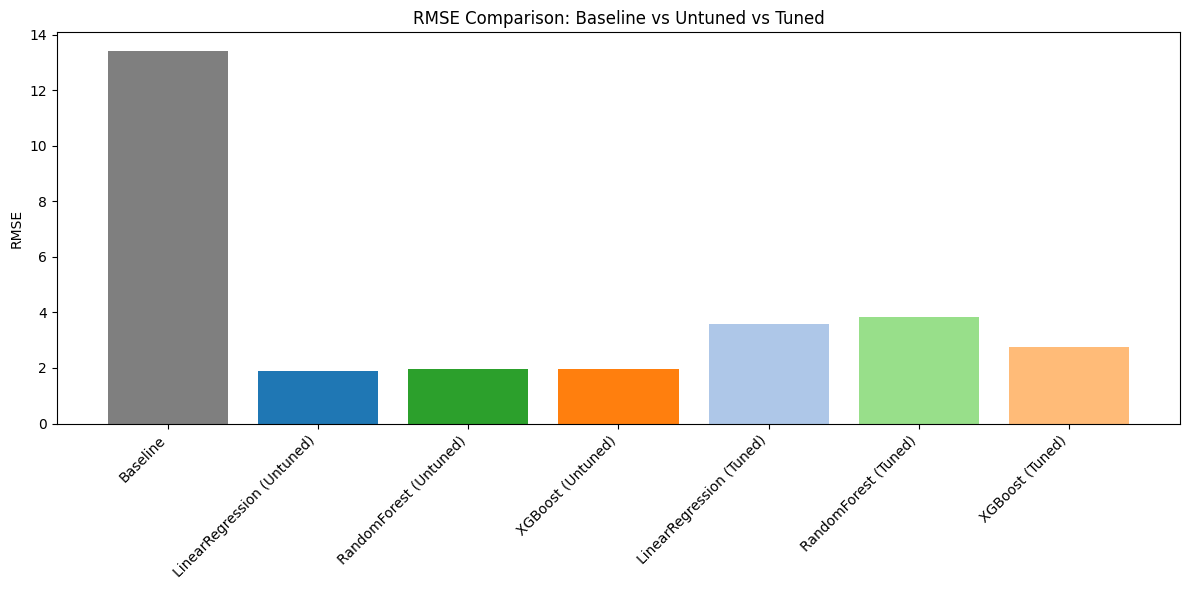

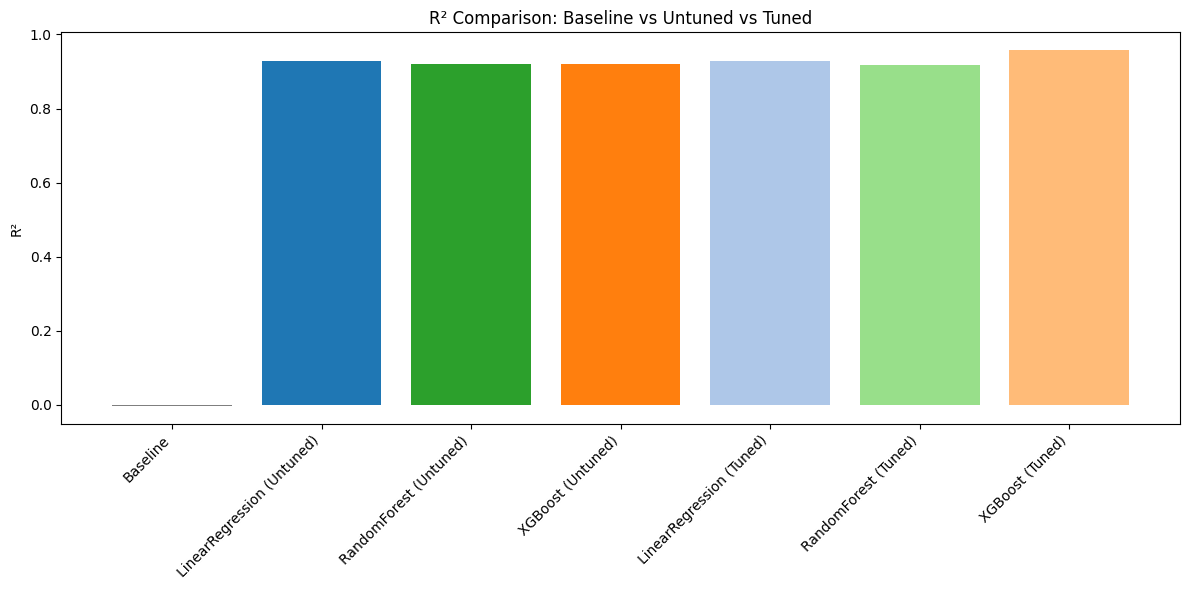

In [13]:
# Data from comparison_df
models = comparison_df['Model']
rmse_values = comparison_df['RMSE']
r2_values = comparison_df['R²']

# Grouped bar chart for RMSE
plt.figure(figsize=(12, 6))

# Define positions
x = np.arange(len(models))

# Colors: same family for each model
colors = []
for m in models:
    if 'LinearRegression' in m:
        colors.append('#1f77b4' if 'Untuned' in m else '#aec7e8')  # Blue shades
    elif 'RandomForest' in m:
        colors.append('#2ca02c' if 'Untuned' in m else '#98df8a')  # Green shades
    elif 'XGBoost' in m:
        colors.append('#ff7f0e' if 'Untuned' in m else '#ffbb78')  # Orange shades
    else:
        colors.append('#7f7f7f')  # Baseline gray

plt.bar(x, rmse_values, color=colors)
plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('RMSE')
plt.title('RMSE Comparison: Baseline vs Untuned vs Tuned')
plt.tight_layout()
plt.show()

# Repeat for R²
plt.figure(figsize=(12, 6))
plt.bar(x, r2_values, color=colors)
plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('R²')
plt.title('R² Comparison: Baseline vs Untuned vs Tuned')
plt.tight_layout()
plt.show()
